In [1]:
import os

import imgaug as ia
import imgaug.augmenters as iaa

import numpy as np
import matplotlib.pyplot as plt
import cv2

from copy import deepcopy

from dataset import custom_dataset as custom_dataset, rotate_vertices, deg2rad, cal_distance, Polygon

In [54]:
def move_points(vertices, index1, index2, r, coef):
    '''move the two points to shrink edge
    Input:
            vertices: vertices of text region <numpy.ndarray, (8,)>
            index1  : offset of point1
            index2  : offset of point2
            r       : [r1, r2, r3, r4] in paper
            coef    : shrink ratio in paper
    Output:
            vertices: vertices where one edge has been shinked
    '''

    print(f">>>move_points: vertices: {vertices}")
    print(f">>>move_points: index1: {index1}")
    print(f">>>move_points: index2: {index2}")
    print(f">>>move_points: r: {r}")
    print(f">>>move_points: coef: {coef}")

    index1 = index1 % 4
    index2 = index2 % 4
    x1_index = index1 * 2 + 0
    y1_index = index1 * 2 + 1
    x2_index = index2 * 2 + 0
    y2_index = index2 * 2 + 1

    r1 = r[index1]
    r2 = r[index2]
    length_x = vertices[x1_index] - vertices[x2_index]
    length_y = vertices[y1_index] - vertices[y2_index]
    length = cal_distance(vertices[x1_index], vertices[y1_index],
                          vertices[x2_index], vertices[y2_index])
    if length > 1:
        ratio_1 = (r1 * coef) / length
        ratio_2 = (r2 * coef) / length
#         vertices[x1_index] += ratio * (-length_x)
#         vertices[y1_index] += ratio * (-length_y)
        vertex_1 = np.array([vertices[x1_index], vertices[y1_index]]).astype(np.float32)
        vertex_2 = np.array([vertices[x2_index], vertices[y2_index]]).astype(np.float32)
        direction_vector = vertex_2 - vertex_1
        
        vertex_1 += ratio_1 * direction_vector
        vertex_2 -= ratio_2 * direction_vector

        
#         vertices[x2_index] += ratio * length_x
#         vertices[y2_index] += ratio * length_y

        vertices[x1_index] = vertex_1[0]
        vertices[y1_index] = vertex_1[1]
        vertices[x2_index] = vertex_2[0]
        vertices[y2_index] = vertex_2[1]

    return vertices


def shrink_poly(vertices, coef: float = 0.3):
    '''shrink the text region
    Input:
            vertices: vertices of text region <numpy.ndarray, (8,)>
            coef    : shrink ratio in paper
    Output:
            v       : vertices of shrinked text region <numpy.ndarray, (8,)>
    '''

    x1, y1, x2, y2, x3, y3, x4, y4 = vertices

    # Eqn. 3
    # r1 = min(D(p1, p2), D(p1, p4))
    # r2 = min(D(p2, p3), D(p2, p1))
    # r3 = min(D(p3, p4), D(p3, p2))
    # r4 = min(D(p4, p1), D(p4, p3))
    r1 = min(cal_distance(x1, y1, x2, y2), cal_distance(x1, y1, x4, y4))
    r2 = min(cal_distance(x2, y2, x1, y1), cal_distance(x2, y2, x3, y3))
    r3 = min(cal_distance(x3, y3, x2, y2), cal_distance(x3, y3, x4, y4))
    r4 = min(cal_distance(x4, y4, x1, y1), cal_distance(x4, y4, x3, y3))
    r = [r1, r2, r3, r4]

    # obtain offset to perform move_points() automatically
    if cal_distance(x1, y1, x2, y2) + cal_distance(x3, y3, x4, y4) > \
            cal_distance(x2, y2, x3, y3) + cal_distance(x1, y1, x4, y4):
        offset = 0  # two longer edges are (x1y1-x2y2) & (x3y3-x4y4)
    else:
        offset = 1  # two longer edges are (x2y2-x3y3) & (x4y4-x1y1)

    v = vertices.copy()
    print(f">>> move point: {0 + offset} and {1 + offset}")
    v = move_points(v, 0 + offset, 1 + offset, r, coef)
    print(f">>> move point: {2 + offset} and {3 + offset}")
    v = move_points(v, 2 + offset, 3 + offset, r, coef)
    
# #     poly_1 = Polygon(np.array(v).reshape(-1, 2))
    
    print(f">>> move point: {3 + offset} and {4 + offset}")
    v = move_points(v, 3 + offset, 4 + offset, r, coef)
    print(f">>> move point: {1 + offset} and {2 + offset}")
    v = move_points(v, 1 + offset, 2 + offset, r, coef)

    
#     poly_2 = Polygon(np.array(v1).reshape(-1, 2))
    
#     poly_1.intersection(poly_2).exterior
#     return poly_1.intersection(poly_2).exterior
    return v

In [55]:
poly = [0, 0, 200, 100, 200, 200, 0, 100]
# rpoly = rotate_vertices(np.array(poly), deg2rad(30))
# rpoly2 = rotate_vertices(np.array(poly), deg2rad(60))
# rpoly3 = rotate_vertices(np.array(poly), deg2rad(90))

In [56]:
shrunked_poly = shrink_poly(poly)
# shrunked_rpoly = shrink_poly(rpoly)
# shrunked_rpoly2 = shrink_poly(rpoly2)
# shrunked_rpoly3 = shrink_poly(rpoly3)

>>> move point: 0 and 1
>>>move_points: vertices: [0, 0, 200, 100, 200, 200, 0, 100]
>>>move_points: index1: 0
>>>move_points: index2: 1
>>>move_points: r: [100.0, 100.0, 100.0, 100.0]
>>>move_points: coef: 0.3
>>> move point: 2 and 3
>>>move_points: vertices: [26.832815, 13.416408, 173.16719, 86.583595, 200, 200, 0, 100]
>>>move_points: index1: 2
>>>move_points: index2: 3
>>>move_points: r: [100.0, 100.0, 100.0, 100.0]
>>>move_points: coef: 0.3
>>> move point: 3 and 4
>>>move_points: vertices: [26.832815, 13.416408, 173.16719, 86.583595, 173.16719, 186.58359, 26.832815, 113.416405]
>>>move_points: index1: 3
>>>move_points: index2: 4
>>>move_points: r: [100.0, 100.0, 100.0, 100.0]
>>>move_points: coef: 0.3
>>> move point: 1 and 2
>>>move_points: vertices: [26.832815, 43.41641, 173.16719, 86.583595, 173.16719, 186.58359, 26.832815, 83.416405]
>>>move_points: index1: 1
>>>move_points: index2: 2
>>>move_points: r: [100.0, 100.0, 100.0, 100.0]
>>>move_points: coef: 0.3


(-10.0, 210.0, -10.0, 210.0)

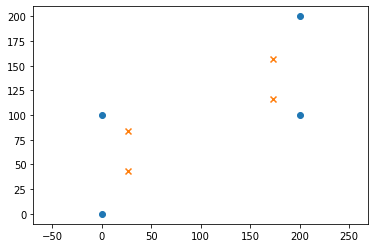

In [57]:
plt.scatter(np.array(poly).reshape(-1, 2)[:,0], np.array(poly).reshape(-1, 2)[:,1])
# plt.scatter(np.array(rpoly).reshape(-1, 2)[:,0], np.array(rpoly).reshape(-1, 2)[:,1])
# plt.scatter(np.array(rpoly2).reshape(-1, 2)[:,0], np.array(rpoly2).reshape(-1, 2)[:,1])
# plt.scatter(np.array(rpoly3).reshape(-1, 2)[:,0], np.array(rpoly3).reshape(-1, 2)[:,1])

plt.scatter(np.array(shrunked_poly).reshape(-1, 2)[:,0], np.array(shrunked_poly).reshape(-1, 2)[:,1], marker="x")
# plt.scatter(np.array(shrunked_rpoly).reshape(-1, 2)[:,0], np.array(shrunked_rpoly).reshape(-1, 2)[:,1], marker="x")
# plt.scatter(np.array(shrunked_rpoly2).reshape(-1, 2)[:,0], np.array(shrunked_rpoly2).reshape(-1, 2)[:,1], marker="x")
# plt.scatter(np.array(shrunked_rpoly3).reshape(-1, 2)[:,0], np.array(shrunked_rpoly3).reshape(-1, 2)[:,1], marker="x")

plt.axis("equal")

In [ ]:
plt.rcParams["figure.figsize"] = 16, 9

In [ ]:
# ICDAR 2015
# train_img_path = os.path.abspath('/mnt/9C5E1A4D5E1A2116/datasets/ICDAR_2015/train_img')
# train_gt_path = os.path.abspath('/mnt/9C5E1A4D5E1A2116/datasets/ICDAR_2015/train_gt')
train_img_path = os.path.abspath('/home/gx/datasets/ICDAR_2015/train_img')
train_gt_path = os.path.abspath('/home/gx/datasets/ICDAR_2015/train_gt')

# SynthText
# train_img_path = os.path.abspath('/mnt/9C5E1A4D5E1A2116/datasets/SynthText/converted/train_img/')
# train_gt_path = os.path.abspath('/mnt/9C5E1A4D5E1A2116/datasets/SynthText/converted/train_gt/')

In [ ]:
trainset = custom_dataset(train_img_path, train_gt_path, 
                          scale=0.25, 
                          normalization_params={
        "mean": (0, 0, 0),
        "std": (1, 1, 1)
    })

In [ ]:
# idx = np.random.randint(len(trainset))
# image, score, geo, ignored, vertices = trainset[idx]
# image = np.array(image)

# for v in vertices:
#     print(v)
#     image = cv2.polylines(image, 
#                           pts=[v.reshape(-1, 2).astype(np.int32)], 
#                           isClosed=True, 
#                           color=(255, 0, 0),
#                           thickness=1)
    
# plt.imshow(image)

In [ ]:
trainset[0]

In [ ]:
idx = np.random.randint(len(trainset))
sample = trainset[idx]

image = sample[0].permute(1, 2, 0).numpy()
plt.imshow(image)

In [ ]:
score_map = sample[1].permute(1, 2, 0).squeeze(-1).numpy()
score_map_resized = (cv2.resize(np.stack([score_map, ] * 3, -1), (512, 512), interpolation=cv2.INTER_AREA) * 255.0).astype(np.uint8)
plt.imshow((score_map_resized * 0.6 + image * 255.0 * 0.4).astype(np.uint8))

In [ ]:
ignored_map = sample[3].permute(1, 2, 0).squeeze(-1).numpy()
ignored_map_resized = (cv2.resize(np.stack([ignored_map, ] * 3, -1), (512, 512)) * 255.0).astype(np.uint8)
plt.imshow((ignored_map_resized * 0.6 + image * 255.0 * 0.4).astype(np.uint8))

In [ ]:
geo_map = sample[2].permute(1, 2, 0).squeeze(-1).numpy()
plt.imshow(geo_map[..., 0].astype(np.uint8))

In [ ]:
geo_map = sample[2].permute(1, 2, 0).squeeze(-1).numpy()
plt.imshow(geo_map[..., 1].astype(np.uint8))

In [ ]:
geo_map = sample[2].permute(1, 2, 0).squeeze(-1).numpy()
plt.imshow(geo_map[..., 2].astype(np.uint8))

In [ ]:
geo_map = sample[2].permute(1, 2, 0).squeeze(-1).numpy()
plt.imshow(geo_map[..., 3].astype(np.uint8))

In [ ]:
geo_map = sample[2].permute(1, 2, 0).squeeze(-1).numpy()
plt.imshow(geo_map[..., 4].astype(np.uint8))

In [ ]:
plt.imshow(score_map)

In [ ]:
ignored_map = sample[3].permute(1, 2, 0).squeeze(-1).numpy()
plt.imshow(ignored_map)